## Classifying Bitcoin Tweet Sentiment

#### Overview

This project seeks to build a model that accurately classifies tweets about Bitcoin as having either positive or negative sentiment. Unlabeled tweets classified by this model could ultimately could be used to analyze time trends on Bitcoin sentiment and assess the predictive power of Twitter sentiment on future price movements of the cryptocurrency.

#### Methods

First, I inspect the data and prepare the text for modeling. Next, I run several machine learning classification models (Multinomial Naive Bayes, Logistic Regression, Linear Support Vector Classifier, Random Forest) with a number of vectorizers (TF-IDF, Count Vectorizer) and hyper-tune to select a best-performing model. Finally, I visually represent model performance and feature importance.

#### Data Sources

The Twitter data is sourced from [Kaggle](https://www.kaggle.com/datasets/gautamchettiar/bitcoin-sentiment-analysis-twitter-data?resource=download) and contains approximately one million tweets about Bitcoin during the period of February to August 2021. The tweets are pre-labeled with positive or negative sentiment, with approximately 53% tagged as negative and 47% positive.



### Import Statements, Data Preparation

In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, gutenberg
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.collocations import *
from wordcloud import WordCloud
from gensim.models import Word2Vec
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

import string
import re
import datetime

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, \
precision_score, confusion_matrix, classification_report, roc_curve, auc, \
average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve

np.random.seed(42) # setting the seed

# only need to run these once
#nltk.download("gutenberg")
#nltk.download("stopwords")
#pip install tweepy

#### Loading and Inspecting Data

Upon initial inspection, it looks like there are some columns that won't be relevant to my analysis and some null values I will need to handle. A few of the columns will also need to be converted to an appropriate data type.

In [2]:
data = pd.read_csv('data/bitcoin_tweets1000000.csv', encoding='ISO-8859-1', index_col=[0])
data.head()

/Users/natalyadoris/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (0,5,6,7,8,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,cleanText,Polarity Score,sentiment
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False,blue ridge bank shares halted nyse bitcoin atm...,0.00,0.0
1,CryptoND,NaN,ð BITCOINLIVE is a Dutch platform aimed at ...,2019-10-17 20:12:10,6769,1532,25483,False,2021-02-10 23:58:48,"ð Today, that's this #Thursday, we will do ...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,today thursday take friend leowandersleb btc w...,0.00,0.0
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False,guys evening read article btc would like share,0.00,0.0
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False,btc big chance billion price bitcoin btc crypto,0.00,0.0
4,Alex Kirchmaier ð¦ð¹ð¸ðª #FactsSupersp...,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False,network secured nodes today soon biggest bears...,-0.25,0.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000025 entries, 0 to 999999
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   user_name         999981 non-null   object 
 1   user_location     536681 non-null   object 
 2   user_description  889249 non-null   object 
 3   user_created      1000000 non-null  object 
 4   user_followers    1000000 non-null  object 
 5   user_friends      1000000 non-null  object 
 6   user_favourites   999997 non-null   object 
 7   user_verified     999996 non-null   object 
 8   date              999995 non-null   object 
 9   text              999993 non-null   object 
 10  hashtags          983199 non-null   object 
 11  source            996633 non-null   object 
 12  is_retweet        999946 non-null   object 
 13  cleanText         999987 non-null   object 
 14  Polarity Score    999988 non-null   float64
 15  sentiment         999986 non-null   float64
dtypes: flo

In [4]:
data.shape

(1000025, 16)

In [5]:
# 53% negative, 47% positive - fairly balanced
print(data[['sentiment']].value_counts(normalize=True))

sentiment
0.0          0.527057
1.0          0.472943
dtype: float64


In [6]:
data.describe()

,Polarity Score,sentiment
count,999988.000000,999986.000000
mean,0.144692,0.472943
std,0.271044,0.499268
min,-1.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.286508,1.000000
max,1.000000,1.000000


In [7]:
data.isna().sum()

user_name               44
user_location       463344
user_description    110776
user_created            25
user_followers          25
user_friends            25
user_favourites         28
user_verified           29
date                    30
text                    32
hashtags             16826
source                3392
is_retweet              79
cleanText               38
Polarity Score          37
sentiment               39
dtype: int64

In [9]:
# loading in bitcoin price data from feb 2021 to aug 2021
btc_price = pd.read_csv('data/BTC-USD.csv')
btc_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-01,33114.578125,34638.214844,32384.228516,33537.175781,33537.175781,61400400660
1,2021-02-02,33533.199219,35896.882813,33489.218750,35510.289063,35510.289063,63088585433
2,2021-02-03,35510.820313,37480.187500,35443.984375,37472.089844,37472.089844,61166818159
3,2021-02-04,37475.105469,38592.175781,36317.500000,36926.066406,36926.066406,68838074392
4,2021-02-05,36931.546875,38225.906250,36658.761719,38144.308594,38144.308594,58598066402


In [10]:
btc_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       212 non-null    object 
 1   Open       212 non-null    float64
 2   High       212 non-null    float64
 3   Low        212 non-null    float64
 4   Close      212 non-null    float64
 5   Adj Close  212 non-null    float64
 6   Volume     212 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 11.7+ KB


#### Initial Data Cleaning

In this section, I will drop irrelevant columns, deal with NaNs, and convert certain columns into the appropriate data type.

In [10]:
# remove columns we don't need
data = data.drop(columns=['user_created', 'cleanText', 'user_location', 
                          'user_description'])

In [11]:
# drop rows where date, text or sentiment is NaN
data = data.dropna(subset=['text', 'date', 'sentiment'])
print(data.shape)
data.isna().sum()

(999986, 12)


user_name             19
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags           16792
source              3357
is_retweet            43
Polarity Score         0
sentiment              0
dtype: int64

The date column needs to be transformed into a datetime format. The below commented out cell results in an error given there is text in some of the dates. The remaining cells handle the transformation.

In [12]:
#data['date'] = [datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in data['date']]
#data.head()

In [13]:
# visually inspecting rows with improperly formatted date data
display(data[data['date'].str.contains('ETH|BTC|btc')]) 
# these columns are shifted two to the right

# what about all columns with missing source and retweet?
data[data['source'].isna() & data['is_retweet'].isna()] # the rest of them look normal

,user_name,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,Polarity Score,sentiment
64943,Can roam the worldï¼It's nine to five againáµ...,36,False,2021-04-07 16:23:03,@krakenfx #ETH #BTC If you want to become po...,"['ETH', 'BTC', 'Bitcoin']",Twitter Web App,False,NaN,NaN,0.0,0.0
137068,*Muhammad Yasir* hello stalker nice to tweet ...,499,False,2021-06-23 14:51:12,Official ESHOP Airdrop. If You Missed Meme Tok...,"['cryptocurrency', 'BSC', 'Bitcoin', 'Ethereum...",Twitter for Android,False,NaN,NaN,0.0,0.0
180575,â¢ Learn n To Do d'Best...!!!!!!!!,127,False,2021-06-22 13:31:16,@pufferswap Nice project\n\n@karnoto_hendrik \...,"['YieldFarming', 'Airdrop', 'Binance', 'Bitcoi...",Twitter Web App,False,NaN,NaN,0.0,0.0
693194,FB- Xiomara CastaÃ±eda,531,False,2021-07-26 11:54:15,#btc to the moon ðð 77774,['btc'],Twitter Web App,False,NaN,NaN,0.0,0.0
697397,Pin bb : 26ea62f8 . Line : baliratih_bali,21,False,2021-07-26 11:48:46,#btc to the moon ðð 46059,['btc'],Twitter Web App,False,NaN,NaN,0.0,0.0


,user_name,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,Polarity Score,sentiment
64943,Can roam the worldï¼It's nine to five againáµ...,36,False,2021-04-07 16:23:03,@krakenfx #ETH #BTC If you want to become po...,"['ETH', 'BTC', 'Bitcoin']",Twitter Web App,False,NaN,NaN,0.000000,0.0
137068,*Muhammad Yasir* hello stalker nice to tweet ...,499,False,2021-06-23 14:51:12,Official ESHOP Airdrop. If You Missed Meme Tok...,"['cryptocurrency', 'BSC', 'Bitcoin', 'Ethereum...",Twitter for Android,False,NaN,NaN,0.000000,0.0
180575,â¢ Learn n To Do d'Best...!!!!!!!!,127,False,2021-06-22 13:31:16,@pufferswap Nice project\n\n@karnoto_hendrik \...,"['YieldFarming', 'Airdrop', 'Binance', 'Bitcoi...",Twitter Web App,False,NaN,NaN,0.000000,0.0
228487,DayTradeIdeas,9190,287,2229,False,2021-06-21 12:17:24,#Bitcoin topped exactly at 1st resistance at 3...,NaN,NaN,NaN,0.250000,1.0
240490,DayTradeIdeas,9191,287,2229,False,2021-06-21 05:19:28,#Bitcoin holding 1st resistance at 36700/37700...,NaN,NaN,NaN,0.000000,0.0
316615,Millionaire Box,225,158,229,False,2021-07-03 12:55:52,Get Paid For Your Opinions! Real Survey Jobs -...,NaN,NaN,NaN,0.200000,1.0
378317,Aldrich Baron,5,12,12,False,2021-07-24 15:45:42,@ShikokuBaby This project looks interesting an...,NaN,NaN,NaN,0.433333,1.0
398481,Evan,57,331,727,False,2021-07-23 17:38:35,@mindfulbtcboss The best way to predict the fu...,NaN,NaN,NaN,0.500000,1.0
398693,Evan,57,331,727,False,2021-07-23 17:27:05,@brucefenton @UofNH @UNH_Police @UNHWildcats @...,NaN,NaN,NaN,0.500000,1.0
398716,Evan,57,331,727,False,2021-07-23 17:25:54,@business The best way to predict the future i...,NaN,NaN,NaN,0.500000,1.0


In [14]:
# dropping rows where date contains text
data = data[~data['date'].str.contains('ETH|BTC|btc')].reset_index(drop=True)

In [15]:
# transforming text data into date format
data['date'] = [datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in data['date']]
data['date'] = pd.to_datetime(data['date']).dt.date

In [16]:
# checking that the dates look right
display(data['date'].max())
display(data['date'].min())

datetime.date(2021, 8, 21)

datetime.date(2021, 2, 5)

In [17]:
# replacing empty retweets with string
data['is_retweet'][data['is_retweet'].isna()] = 'n/a'

<ipython-input-17-806753b2bf5c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_retweet'][data['is_retweet'].isna()] = 'n/a'


In [11]:
# converting date to datetime format
btc_price['Date'] = [datetime.datetime.strptime(date, '%Y-%m-%d') \
                     for date in btc_price['Date']]
#btc_price['Date'] = pd.to_datetime(btc_price['Date']).dt.date

# dataframe with just date and closing price
price_df = btc_price[['Date', 'Close']]
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    212 non-null    datetime64[ns]
 1   Close   212 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


### Text Preprocessing & Feature Engineering

In this section I will take a deeper look at the actual Tweet content and prepare it for modeling.

In [19]:
# only keeping the relevant columns
text_data = data[['text', 'date', 'sentiment', 'is_retweet']]
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999981 entries, 0 to 999980
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   text        999981 non-null  object 
 1   date        999981 non-null  object 
 2   sentiment   999981 non-null  float64
 3   is_retweet  999981 non-null  object 
dtypes: float64(1), object(3)
memory usage: 30.5+ MB


In [20]:
text_data['text'][1]

'ð\x9f\x98\x8e Today, that\'s this #Thursday, we will do a "ð\x9f\x8e¬ Take 2" with our friend @LeoWandersleb, #Btc #wallet #security expeâ\x80¦ https://t.co/go6aDgRml5'

I will use regex to handle some of the unwanted text, such as urls and Twitter handles.

In [21]:
#url pattern - want to remove
pattern = "(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])"
print(re.findall(pattern, text_data['text'][0]))

#pattern = "(http|ftp|https):\/\/t.co\/[a-zA-Z0-9\-\.]{8}"
pattern = "(http|ftp|https):\/\/(t.co\/[a-zA-Z0-9\-\.]{8})"
print(re.findall(pattern, text_data['text'][0]))

pattern = "https:\/\/t.co\/[a-zA-Z0-9\-\.]{8}"
print(re.findall(pattern, text_data['text'][0]))

# apostrophe pattern
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
print(re.findall(pattern, text_data['text'][0]))

[('https', 't.co', '/xaaZmaJKiV'), ('https', 't.co', '/sgBxMkP1SI')]
[('https', 't.co/xaaZmaJK'), ('https', 't.co/sgBxMkP1')]
['https://t.co/xaaZmaJK', 'https://t.co/sgBxMkP1']
['Blue', 'Ridge', 'Bank', 'shares', 'halted', 'by', 'NYSE', 'after', 'bitcoin', 'ATM', 'announcement', 'https', 't', 'co', 'xaaZmaJKiV', 'MyBlueRidgeBank', 'https', 't', 'co', 'sgBxMkP', 'SI']


In [22]:
# removing all urls

pattern_https = "https:\/\/t.co\/[a-zA-Z0-9\-\.]{8}"
pattern_www = "www\.[a-z]?\.?(com)+|[a-z]+\.(com)"
#string = text_data['text'][1]
repl = ''

#text_ex = re.sub(pattern_http, repl, string, count=0, flags=0)

text_data['text'] = [re.sub(pattern_https, repl, string, count=0, flags=0)\
                     for string in text_data['text']]
text_data['text'] = [re.sub(pattern_www, repl, string, count=0, flags=0)\
                     for string in text_data['text']]

text_data['text'][1]

#pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
#print(re.findall(pattern, text_ex))

<ipython-input-22-f020dda00306>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['text'] = [re.sub(pattern_https, repl, string, count=0, flags=0)\
<ipython-input-22-f020dda00306>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['text'] = [re.sub(pattern_www, repl, string, count=0, flags=0)\


'ð\x9f\x98\x8e Today, that\'s this #Thursday, we will do a "ð\x9f\x8e¬ Take 2" with our friend @LeoWandersleb, #Btc #wallet #security expeâ\x80¦ l5'

In [23]:
# remove twitter handles

pattern_handle = "@[A-Za-z0-9]+"
repl = ''

text_data['text'] = [re.sub(pattern_handle, repl, string, count=0, flags=0)\
                     for string in text_data['text']]

<ipython-input-23-265c887e34dc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['text'] = [re.sub(pattern_handle, repl, string, count=0, flags=0)\


In [24]:
# remove numbers

pattern_num = r"\b\d+\b" #"\b(\d+)\b"
repl = ''

#print(re.findall(pattern_num, text_data['text'][3]))

text_data['text'] = [re.sub(pattern_num, repl, string, count=0, flags=0)\
                     for string in text_data['text']]

text_data['text'].head()

<ipython-input-24-e2631955cc8c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['text'] = [re.sub(pattern_num, repl, string, count=0, flags=0)\


0    Blue Ridge Bank shares halted by NYSE after #b...
1    ð Today, that's this #Thursday, we will do ...
2    Guys evening, I have read this article about B...
3    $BTC A big chance in a billion! Price: \. (// ...
4    This network is secured by   nodes as of today...
Name: text, dtype: object

Converting everything into lower case so that we don't treat the same word with different casing as different words.

In [25]:
text_data['text'] = text_data["text"].str.lower()

<ipython-input-25-4b865df3999c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['text'] = text_data["text"].str.lower()


Looking at how different tokenizers treat the text data:

In [26]:
tweet_tokenizer = TweetTokenizer()
print(tweet_tokenizer.tokenize(text_data['text'][3]))
print(text_data['text'][3])
#text_data['tweet_tokenized'] = text_data["text"].apply(tweet_tokenizer.tokenize)

['$', 'btc', 'a', 'big', 'chance', 'in', 'a', 'billion', '!', 'price', ':', '\\', '.', '(', '/', '/', ':)', '#bitcoin', '#fx', '#btc', '#crypto']
$btc a big chance in a billion! price: \. (// :) #bitcoin #fx #btc #crypto


In [27]:
# tokenizing with regex tokenizer
basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)
tokenizer.tokenize(text_data['text'][3])

['btc',
 'big',
 'chance',
 'in',
 'billion',
 'price',
 'bitcoin',
 'fx',
 'btc',
 'crypto']

The regex tokenizer seems to isolate just the key words in the text. We will go with this one.

In [28]:
# tokenizing with regex tokenizer
basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)

# Create new column with tokenized data
text_data["text_tokenized"] = text_data["text"].apply(tokenizer.tokenize)

<ipython-input-28-f44a4f87e3e5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data["text_tokenized"] = text_data["text"].apply(tokenizer.tokenize)


The below code replaces domain-specific abbreviations with the full word. This will be helpful for visualizations. Some groupings include: btc/bitcoin, eth/ethereum, crypto/cryptocurrency, doge/dogecoin.



In [29]:
# abbreviation dictionary
abbv_dict = {'btc': 'bitcoin', 
             'ethereum': 'eth', 
             'cryptocurrency': 'crypto', 
             'dogecoin': 'doge'}

# tokenized text back to single string for functionality
text_data['text2'] = [" ".join(lst) for lst in text_data['text_tokenized']]

# replacing key with value
for key in abbv_dict.keys():
    text_data['text2'] = [text_str.replace(key, abbv_dict[key]) for text_str in text_data['text2']]

# before and after    
print(text_data['text'][1])
print(text_data['text2'][1])

<ipython-input-29-b4dab91e48a2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['text2'] = [" ".join(lst) for lst in text_data['text_tokenized']]
<ipython-input-29-b4dab91e48a2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['text2'] = [text_str.replace(key, abbv_dict[key]) for text_str in text_data['text2']]


ð today, that's this #thursday, we will do a "ð¬ take " with our friend , #btc #wallet #security expeâ¦ l5
today that this thursday we will do take with our friend bitcoin wallet security expeâ l5


Confirming that the transformations worked:

In [30]:
print(text_data['text'][20000])
print(text_data['text2'][20000])

this is a nice setup for #btc to make a run back to ath. #bitcoin x5
this is nice setup for bitcoin to make run back to ath bitcoin x5


Tokenizing the new text data:

In [31]:
# tokenizing with regex tokenizer
basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)

# Create new column with tokenized data
text_data["text_tokenized"] = text_data["text2"].apply(tokenizer.tokenize)
text_data['text_tokenized'][1]

<ipython-input-31-1a2d027bd0bf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data["text_tokenized"] = text_data["text2"].apply(tokenizer.tokenize)


['today',
 'that',
 'this',
 'thursday',
 'we',
 'will',
 'do',
 'take',
 'with',
 'our',
 'friend',
 'bitcoin',
 'wallet',
 'security',
 'expeâ',
 'l5']

Creating a column that contains a list of the hashtags in each tweet:

In [32]:
text_data['hashtag'] = text_data['text'].\
apply(lambda x: re.findall(r'\B#\w*[a-zA-Z]+\w*', x))

<ipython-input-32-271edba60584>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['hashtag'] = text_data['text'].\


In [33]:
# visually inspecting
display(text_data.head())

,text,date,sentiment,is_retweet,text_tokenized,text2,hashtag
0,blue ridge bank shares halted by nyse after #b...,2021-02-10,0.0,False,"[blue, ridge, bank, shares, halted, by, nyse, ...",blue ridge bank shares halted by nyse after bi...,[#bitcoin]
1,"ð today, that's this #thursday, we will do ...",2021-02-10,0.0,False,"[today, that, this, thursday, we, will, do, ta...",today that this thursday we will do take with ...,"[#thursday, #btc, #wallet, #security]"
2,"guys evening, i have read this article about b...",2021-02-10,0.0,False,"[guys, evening, have, read, this, article, abo...",guys evening have read this article about bitc...,[]
3,$btc a big chance in a billion! price: \. (// ...,2021-02-10,0.0,False,"[bitcoin, big, chance, in, billion, price, bit...",bitcoin big chance in billion price bitcoin fx...,"[#bitcoin, #fx, #btc, #crypto]"
4,this network is secured by nodes as of today...,2021-02-10,0.0,False,"[this, network, is, secured, by, nodes, as, of...",this network is secured by nodes as of today s...,[#btc]


Now, we will remove stopwords and punctuation.

In [11]:
# storing stopwords list and adding punctuation
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

# function to remove stopwords
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    return [word for word in token_list if word not in stopwords_list]

In [35]:
# applying remove stopwords function
text_data["text_without_stopwords"] = text_data["text_tokenized"].apply(remove_stopwords)

<ipython-input-35-0e64d31a4f6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data["text_without_stopwords"] = text_data["text_tokenized"].apply(remove_stopwords)


Adding in some columns that represent the number of hashtags per tweet, as well as the length of each tweet, and whether the tweet contains a price.

In [36]:
# count of hashtags

text_data['hashtag_count'] = [len(x) for x in text_data['hashtag']]

<ipython-input-36-d813cf7205a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['hashtag_count'] = [len(x) for x in text_data['hashtag']]


In [37]:
# tweet length

text_data['tweet_length'] = [len(x) for x in text_data['text_tokenized']]

<ipython-input-37-a746883ab5df>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['tweet_length'] = [len(x) for x in text_data['text_tokenized']]


In [38]:
# adding column showing whether the tweet contains price

price_query = r'\$(?:\d{1,3}[,.]?)+(?:\\d{1,2})?'
text_data["contains_price"] = text_data["text"].str.contains(price_query)

<ipython-input-38-66081249b850>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data["contains_price"] = text_data["text"].str.contains(price_query)


Visually inspecting the data one last time. We can see that final tokenized text is lowercased, without urls, stopwords & numbers, and that our feature engineered columns have been added.

In [39]:
text_data.info() # reinspecting datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999981 entries, 0 to 999980
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   text                    999981 non-null  object 
 1   date                    999981 non-null  object 
 2   sentiment               999981 non-null  float64
 3   is_retweet              999981 non-null  object 
 4   text_tokenized          999981 non-null  object 
 5   text2                   999981 non-null  object 
 6   hashtag                 999981 non-null  object 
 7   text_without_stopwords  999981 non-null  object 
 8   hashtag_count           999981 non-null  int64  
 9   tweet_length            999981 non-null  int64  
 10  contains_price          999981 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 77.2+ MB


In [40]:
display(text_data.head())

,text,date,sentiment,is_retweet,text_tokenized,text2,hashtag,text_without_stopwords,hashtag_count,tweet_length,contains_price
0,blue ridge bank shares halted by nyse after #b...,2021-02-10,0.0,False,"[blue, ridge, bank, shares, halted, by, nyse, ...",blue ridge bank shares halted by nyse after bi...,[#bitcoin],"[blue, ridge, bank, shares, halted, nyse, bitc...",1,13,False
1,"ð today, that's this #thursday, we will do ...",2021-02-10,0.0,False,"[today, that, this, thursday, we, will, do, ta...",today that this thursday we will do take with ...,"[#thursday, #btc, #wallet, #security]","[today, thursday, take, friend, bitcoin, walle...",4,16,False
2,"guys evening, i have read this article about b...",2021-02-10,0.0,False,"[guys, evening, have, read, this, article, abo...",guys evening have read this article about bitc...,[],"[guys, evening, read, article, bitcoin, would,...",0,18,False
3,$btc a big chance in a billion! price: \. (// ...,2021-02-10,0.0,False,"[bitcoin, big, chance, in, billion, price, bit...",bitcoin big chance in billion price bitcoin fx...,"[#bitcoin, #fx, #btc, #crypto]","[bitcoin, big, chance, billion, price, bitcoin...",4,10,False
4,this network is secured by nodes as of today...,2021-02-10,0.0,False,"[this, network, is, secured, by, nodes, as, of...",this network is secured by nodes as of today s...,[#btc],"[network, secured, nodes, today, soon, biggest...",1,22,False


### Data Exploration 

First, let's look at how balanced (or unbalanced) our dataset is. This looks fairly balanced to me, with slightly more tweets having negative sentiment.

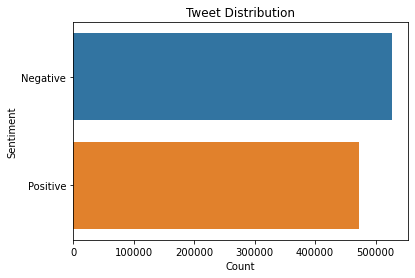

In [8]:
# dataset looks fairly balanced
ax = sns.countplot(data = text_data, y = 'sentiment')
ax.set(xlabel='Count', ylabel='Sentiment', title='Tweet Distribution')
ax.set_yticklabels(['Negative', 'Positive'])
plt.savefig('images/tweet_distribution.png')

Looking at the price of Bitcoin during the same period as our Twitter data, as well as the average daily sentiment from the Tweets & daily volume. I want to see whether days of high Bitcoin Twitter volume correspond with days of overwhelmingly positive or negative sentiment. I also want to see how the price of Bitcoin moved during this time period.

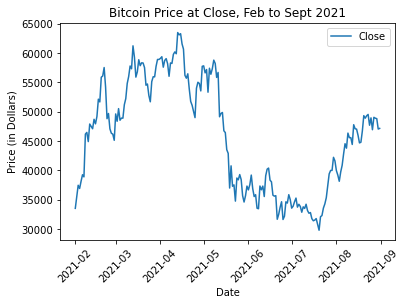

In [33]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m')

# price of bitcoin from feb 2021 to sept 2021
price_df.plot(x='Date')
plt.xticks(rotation=45)
plt.ylabel('Price (in Dollars)')
plt.title('Bitcoin Price at Close, Feb to Sept 2021')
ax.xaxis.set_major_formatter(myFmt)

72

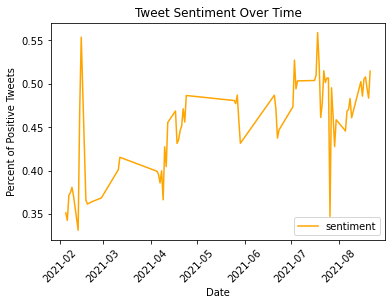

In [55]:
# percent of positive tweets per day
grouped = text_data[['date', 'sentiment']].groupby('date').mean().reset_index()
grouped['date'] = pd.to_datetime(grouped['date']).dt.date
grouped.plot(x='date', c='orange')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Percent of Positive Tweets')
plt.title('Tweet Sentiment Over Time')
len(grouped) # only 72 observations (unique days with tweets)

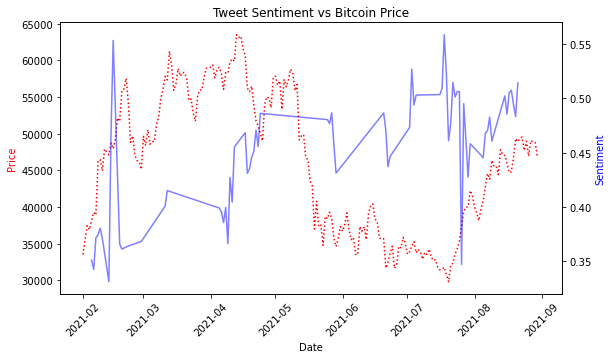

In [89]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(9,5))
# make a plot
ax.plot(price_df.Date, price_df.Close, color="red", linestyle='dotted')
# set x-axis label
ax.set_xlabel("Date", fontsize = 10)
# set y-axis label
ax.set_ylabel("Price",color="red", fontsize=10)
plt.xticks(rotation=45)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(grouped.date, grouped.sentiment, color="blue", alpha=0.5)
ax2.set_ylabel("Sentiment",color="blue",fontsize=10)

# title, show and save figure
plt.title('Tweet Sentiment vs Bitcoin Price')
plt.savefig('images/tweet_sentiment_vs_bitcoin_px.png')

Daily volume of Tweets on Bitcoin:

Text(0.5, 1.0, 'Number of Tweets')

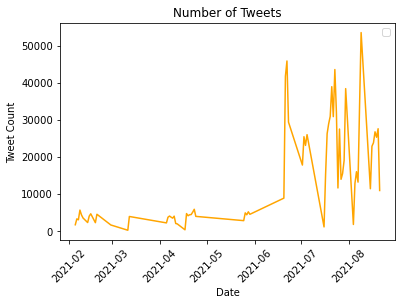

In [63]:
# count of tweets per day

count = text_data[['date', 'sentiment']].groupby('date').count().reset_index()
count['date'] = pd.to_datetime(count['date']).dt.date
count.plot(x='date', c='orange') # seems like activity spikes in the summer
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Tweet Count')
plt.legend('')
plt.title('Number of Tweets')

Bitcoin price & volume of tweets:

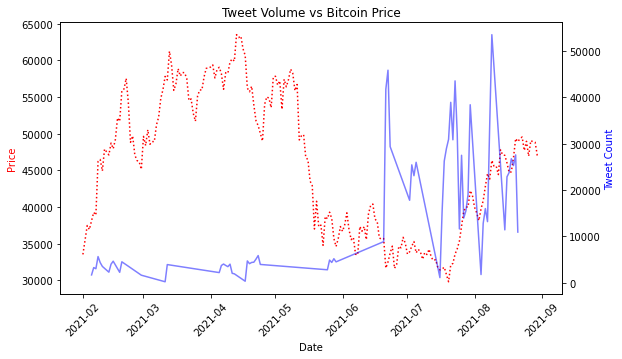

In [90]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(9,5))
# make a plot
ax.plot(price_df.Date, price_df.Close, color="red", linestyle='dotted')
# set x-axis label
ax.set_xlabel("Date", fontsize = 10)
# set y-axis label
ax.set_ylabel("Price", color="red", fontsize=10)
plt.xticks(rotation=45)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(count.date, count.sentiment, color="blue", alpha=0.5)
ax2.set_ylabel("Tweet Count",color="blue",fontsize=10)

# title, show and save figure
plt.title('Tweet Volume vs Bitcoin Price')
plt.savefig('images/tweet_volume_vs_bitcoin_px.png')

Sentiment overlayed with Tweet Volume:

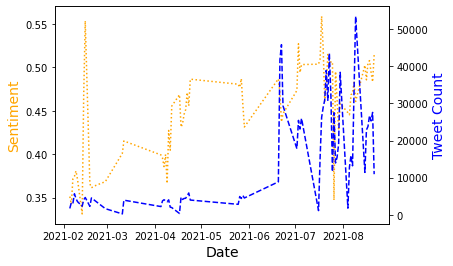

In [79]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(grouped.date, grouped.sentiment,color="orange", linestyle='dotted')
# set x-axis label
ax.set_xlabel("Date", fontsize = 14)
# set y-axis label
ax.set_ylabel("Sentiment", color="orange",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(count.date, count.sentiment, color="blue", linestyle='dashed')
ax2.set_ylabel("Tweet Count",color="blue",fontsize=14)
plt.show()

Now, we look at the most common words, across all tweets, then positive & negative separately. There doesn't seem to be much of a distinction between positive and negative tweets in terms of the most frequent words. Perhaps bigrams would be more helpful to look at.

In [48]:
# distribution of most frequent words
freq_dist = FreqDist(text_data["text_without_stopwords"].explode())

In [49]:
# converting this into a dataframe
freq_dist_df = pd.DataFrame(pd.Series(freq_dist), columns=['count'])
freq_dist_df.head()

,count
blue,2643
ridge,67
bank,6923
shares,3063
halted,39


In [50]:
# how does subsetting our text data by frequency reduce the set of words?

display(freq_dist_df.sort_values(by='count', ascending=False))

print("Total number of unique words: ", len(freq_dist_df))
print("Words appearing more than once: ", len(freq_dist_df[freq_dist_df['count']>1]))
print("Words appearing five or more times: ", len(freq_dist_df[freq_dist_df['count']>=5]))
print("Words appearing 10 or more times: ", len(freq_dist_df[freq_dist_df['count']>=10]))
print("Words appearing 50 or more times: ", len(freq_dist_df[freq_dist_df['count']>=50]))
print("Words appearing 5000 or more times: ", len(freq_dist_df[freq_dist_df['count']>=5000]))

,count
bitcoin,1421651
crypto,449316
eth,249670
project,145770
doge,122002
...,...
leprechauns,1
banshees,1
uspresidentjoebiden,1
section230,1


Total number of unique words:  215464
Words appearing more than once:  101721
Words appearing five or more times:  53081
Words appearing 10 or more times:  35318
Words appearing 50 or more times:  14612
Words appearing 5000 or more times:  450


In [51]:
def visualize_top_10(freq_dist, title):
    
    '''
    Function to visualize the top 10 most common words
    '''
    # data gathering
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # plotting
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

In [52]:
def visualize_top_20(freq_dist, title):
    
    '''
    Function to visualize the top 20 most common words
    '''

    # data gathering
    top_20 = list(zip(*freq_dist.most_common(20)))
    tokens = top_20[0]
    counts = top_20[1]

    # plotting
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

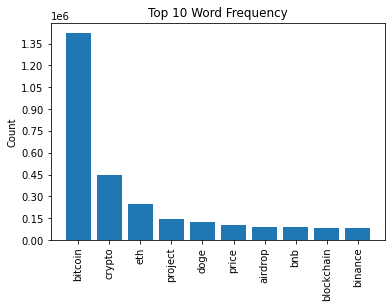

In [53]:
# top 10 word freq for all tweets
sample_freq_dist = FreqDist(text_data["text_without_stopwords"].explode())
visualize_top_10(sample_freq_dist, "Top 10 Word Frequency")

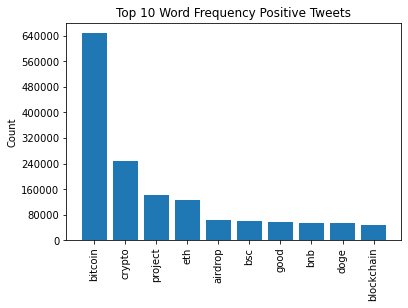

In [54]:
# top 10 word freq for positive tweets  
sample_freq_dist = FreqDist(text_data["text_without_stopwords"][text_data['sentiment']==1].explode())
visualize_top_10(sample_freq_dist, "Top 10 Word Frequency Positive Tweets")

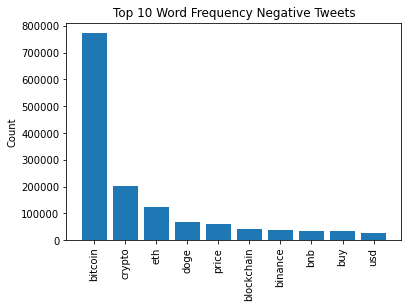

In [55]:
# top 10 word freq for negative tweets  
sample_freq_dist = FreqDist(text_data["text_without_stopwords"][text_data['sentiment']==0].explode())
visualize_top_10(sample_freq_dist, "Top 10 Word Frequency Negative Tweets")

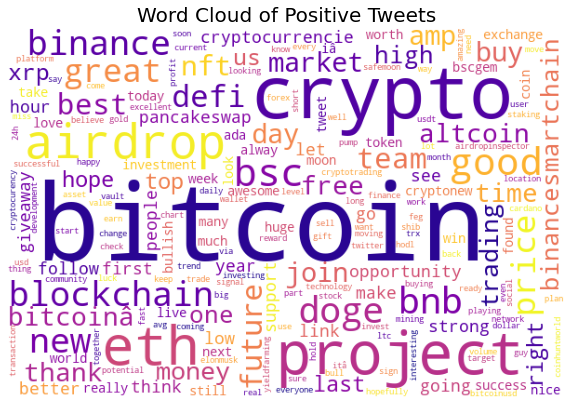

In [56]:
# word cloud for positive sentiment tweets
wordcloud = WordCloud(max_words = 200, stopwords = None, collocations = False, 
                      width = 600, height = 400, background_color = 'white', 
                      colormap = 'plasma') 
wordcloud.generate(",".join(text_data["text_without_stopwords"]\
                            [text_data['sentiment']==1].explode())) 
            
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of Positive Tweets', fontsize=20)
plt.savefig('images/positive_wordcloud.png')

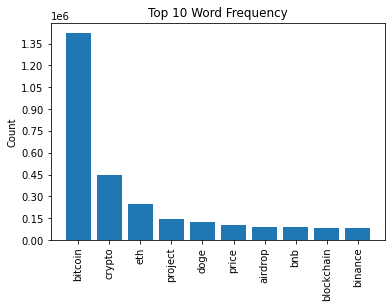

In [57]:
# top 10 word freq for all tweets  
sample_freq_dist = FreqDist(text_data["text_without_stopwords"].explode())
visualize_top_10(sample_freq_dist, "Top 10 Word Frequency")

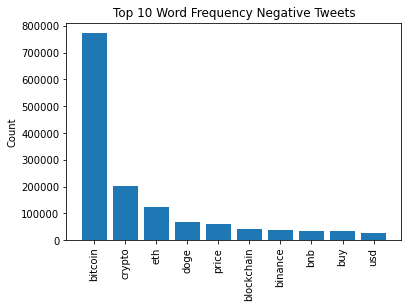

In [58]:
# top 10 word freq for positive tweets  
sample_freq_dist = FreqDist(text_data["text_without_stopwords"][text_data['sentiment']==0].explode())
visualize_top_10(sample_freq_dist, "Top 10 Word Frequency Negative Tweets")

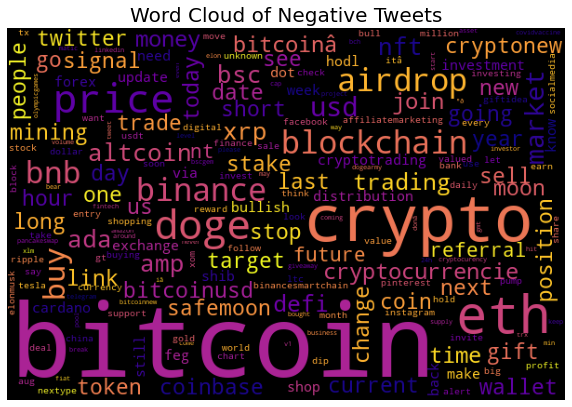

In [59]:
# word cloud for negative sentiment tweets
wordcloud = WordCloud(max_words = 200, stopwords = None, collocations = False, 
                      width = 600, height = 400, background_color = 'black', 
                      colormap = 'plasma') 

wordcloud.generate(",".join(map(str,text_data["text_without_stopwords"]\
                                [text_data['sentiment']==0].explode()))) 
                    
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of Negative Tweets', fontsize=20)
plt.savefig('images/negative_wordcloud.png')

Based on the distribution of hashtag count across positive and negative tweets, it seems as though negative tweets tend to have more hashtags. Again, there doesn't seem to be much of a distinction between positive and negative tweets when it comes to the most frequent words used in hashtags.

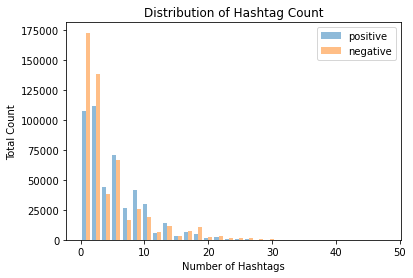

In [60]:
# hashtag distribution
plt.hist([text_data['hashtag_count'][text_data['sentiment']==1], 
          text_data['hashtag_count'][text_data['sentiment']==0]], 
         bins=30, alpha=0.5, label=['positive', 'negative'])
plt.legend(loc='upper right')
plt.xlabel('Number of Hashtags')
plt.ylabel('Total Count')
plt.title('Distribution of Hashtag Count')
plt.show()

Text(0.5, 1.0, 'Average Hashtag Count by Sentiment')

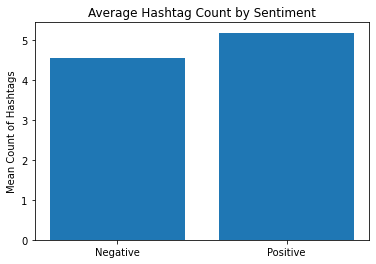

In [61]:
# grouping hashtag count by sentiment

h_count = text_data[['sentiment', 'hashtag_count']].groupby('sentiment').mean().reset_index()
plt.bar(x='sentiment', height='hashtag_count', data=h_count, label=['Positive', 'Negative'])
plt.xticks(h_count['sentiment'], ['Negative', 'Positive'])
plt.ylabel('Mean Count of Hashtags')
plt.title('Average Hashtag Count by Sentiment')

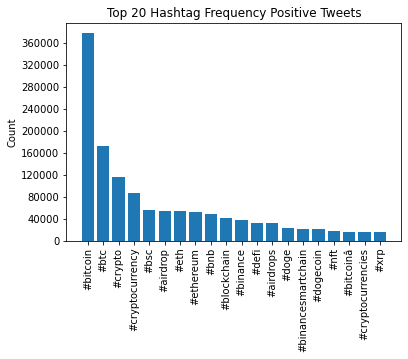

In [62]:
# top 20 hashtag freq for positive tweets  
sample_freq_dist = FreqDist(text_data["hashtag"][text_data['sentiment']==1].explode())
visualize_top_20(sample_freq_dist, "Top 20 Hashtag Frequency Positive Tweets")

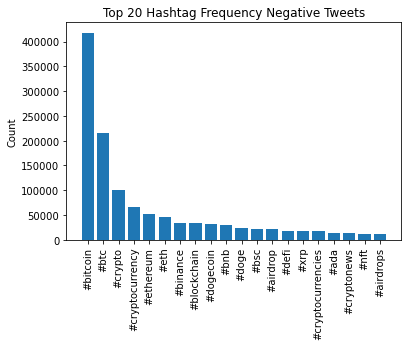

In [63]:
# top hashtags for negative tweets
sample_freq_dist = FreqDist(text_data["hashtag"][text_data['sentiment']==0].explode())
visualize_top_20(sample_freq_dist, "Top 20 Hashtag Frequency Negative Tweets")

None of the tweets are retweets, it seems. We can get rid of this column.

In [64]:
# is retweet grouped by sentiment

r_count = text_data[['sentiment', 'is_retweet']].groupby('is_retweet').count().reset_index()
r_count # no retweets

,is_retweet,sentiment
0,False,967198
1,False,32745
2,n/a,38


In [65]:
# dropping is_retweet column since the only values are False and N/A
text_data = text_data.drop('is_retweet', axis=1)

Finally, a plot looking at the tweets that contain a price value. Negative tweets tend to have a price more frequently than positive tweets.

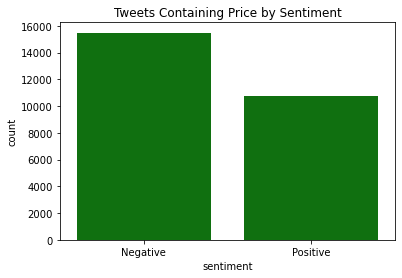

In [26]:
g = sns.countplot(x=text_data['sentiment'][text_data['contains_price']==1], 
                  label=['Positive', 'Negative'], color='g')
g.set_title("Tweets Containing Price by Sentiment")
g.set_xticklabels(['Negative', 'Positive'])
plt.savefig('images/contains_price.png')

### Preparing to Model

Here, I created a number of functions to help streamline the modeling process.

In [2]:
''' 
Function that stores relevant scoring metrics
'''

def return_scores(y_train, y_hat_train, y_test, y_hat_test):
    #r_train = recall_score(y_train, y_hat_train)
    #r_test = recall_score(y_test, y_hat_test)
         
    f1_train = f1_score(y_train, y_hat_train)
    f1_test = f1_score(y_test, y_hat_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    pr_auc = average_precision_score(y_test, y_hat_test)
    
    ac_train = accuracy_score(y_train, y_hat_train)
    ac_test = accuracy_score(y_test, y_hat_test)
    
    return f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc

In [4]:
## ADD RUNTIME COLUMN? ##

'''
Creates a data frame with various scores for each model
'''
# column names
scores = pd.DataFrame(columns = ['f1_train', 'f1_test', 'accuracy_train', 
                                 'accuracy_test', 'roc_auc', 'pr_auc', 
                                 'model', 'vectorizer'])
    

def scoreTable(model, model_name, vectorizer, y_train, y_hat_train, y_test, y_hat_test):
    
    # storing scores
    f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc = \
    return_scores(y_train, y_hat_train, y_test, y_hat_test)
    
    # list of scores
    score_list = []
    score_list.extend((f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc, 
                       str(model), str(vectorizer)))
    
    # adding scores to score table
    scores.loc[model_name] = score_list
    return scores

In [5]:
'''
Putting it all together, function that runs and evaluates model
'''

def model_eval(model, model_name, vectorizer):
    
    X_train_vectorized = vectorizer.fit_transform(X_train['text'])
    model.fit(X_train_vectorized, y_train)
    
    X_test_vectorized = vectorizer.transform(X_test['text'])
    
    y_hat_train = model.predict(X_train_vectorized)
    y_hat_test = model.predict(X_test_vectorized)
    
    col_names = vectorizer.get_feature_names()
    
    return scoreTable(model, model_name, vectorizer, y_train, y_hat_train, 
                      y_test, y_hat_test) 

# could try using pipeline here next

In [6]:
'''
Function that runs, evaluates model and stores variables
'''

def model_eval_store(model, model_name, vectorizer):
    
    X_train_vectorized = vectorizer.fit_transform(X_train['text'])
    model.fit(X_train_vectorized, y_train)
    
    X_test_vectorized = vectorizer.transform(X_test['text'])
    
    y_hat_train = model.predict(X_train_vectorized)
    y_hat_test = model.predict(X_test_vectorized)
    
    col_names = vectorizer.get_feature_names()
    
    return X_train_vectorized, X_test_vectorized, y_hat_train, y_hat_test, col_names, \
    scoreTable(model, model_name, vectorizer, y_train, y_hat_train, y_test, y_hat_test) 

### Train Test Split

Splitting the data into train / test sets for model evaluation.

In [71]:
text_data.head()

,text,date,sentiment,text_tokenized,text2,hashtag,text_without_stopwords,hashtag_count,tweet_length,contains_price
0,blue ridge bank shares halted by nyse after #b...,2021-02-10,0.0,"[blue, ridge, bank, shares, halted, by, nyse, ...",blue ridge bank shares halted by nyse after bi...,[#bitcoin],"[blue, ridge, bank, shares, halted, nyse, bitc...",1,13,False
1,"ð today, that's this #thursday, we will do ...",2021-02-10,0.0,"[today, that, this, thursday, we, will, do, ta...",today that this thursday we will do take with ...,"[#thursday, #btc, #wallet, #security]","[today, thursday, take, friend, bitcoin, walle...",4,16,False
2,"guys evening, i have read this article about b...",2021-02-10,0.0,"[guys, evening, have, read, this, article, abo...",guys evening have read this article about bitc...,[],"[guys, evening, read, article, bitcoin, would,...",0,18,False
3,$btc a big chance in a billion! price: \. (// ...,2021-02-10,0.0,"[bitcoin, big, chance, in, billion, price, bit...",bitcoin big chance in billion price bitcoin fx...,"[#bitcoin, #fx, #btc, #crypto]","[bitcoin, big, chance, billion, price, bitcoin...",4,10,False
4,this network is secured by nodes as of today...,2021-02-10,0.0,"[this, network, is, secured, by, nodes, as, of...",this network is secured by nodes as of today s...,[#btc],"[network, secured, nodes, today, soon, biggest...",1,22,False


In [7]:
# saving to csv file so that we do not have to rerun all of the above code
# if we restart the kernel. uncomment if any changes to the above made
#text_data.to_csv('data/text_data_preprocessed.csv')

# uncomment the following if kernel is restarted
text_data = pd.read_csv('data/text_data_preprocessed.csv')

In [8]:
X = text_data.drop('sentiment', axis=1)
y = text_data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
print(y_train.value_counts(normalize=True)) #fairly balanced
print(y_test.value_counts(normalize=True))

0.0    0.527191
1.0    0.472809
Name: sentiment, dtype: float64
0.0    0.526648
1.0    0.473352
Name: sentiment, dtype: float64


### Models

#### Baseline Model

Our baseline model is a Naive Bayers classifier with a TF-IDF Vectorizer. Resulting in 81% accuracy, I hope to make some improvements with different vectorizers and classifiers.

In [75]:
# Instantiate a MultinomialNB classifier as baseline model
baseline_model = MultinomialNB()

In [76]:
tfidf = TfidfVectorizer(max_features=450) # includes words that occur 5000 or more times

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['text'])

# Visually inspecting the matrix
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,24h,_binance,_saylor,about,above,ada,address,affiliatemarketing,after,again,...,would,xlm,xom,xrp,year,years,yieldfarming,you,your,ºð
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.35151,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
749981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0
749982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.157626,0.0,0.0
749983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0


In [77]:
# We should still have the same number of rows
assert X_train_vectorized.shape[0] == X_train.shape[0]

# The vectorized version should have 450 columns, since max_features=450
assert X_train_vectorized.shape[1] == 450

In [78]:
# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv

array([0.80949619, 0.81026954, 0.8099162 , 0.80902285, 0.80762282])

In [79]:
# add baseline to score table

# fit on train, transform test
baseline_model.fit(X_train_vectorized, y_train)
X_test_vectorized = tfidf.transform(X_test['text'])

# store y_hats
y_hat_train_baseline = baseline_model.predict(X_train_vectorized)
y_hat_test_baseline = baseline_model.predict(X_test_vectorized)

# add to score table
display(scoreTable(baseline_model, 'baseline', tfidf, y_train, 
                   y_hat_train_baseline, y_test, y_hat_test_baseline))

,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,model,vectorizer
baseline,0.786558,0.786891,0.809624,0.809601,0.806211,0.74324,MultinomialNB(),TfidfVectorizer(max_features=450)


#### Vectorizer Tuning

First, I will look at how changing the vectorizer affects the performance of the baseline model.

In [80]:
# running different vectorizers on same model, hypertuning vectorizers
runs = [(MultinomialNB(), 'baseline_tfidf2', TfidfVectorizer(max_features=450, stop_words=stopwords_list)), 
        (MultinomialNB(), 'baseline_tfidf3', TfidfVectorizer(stop_words=stopwords_list)),
        (MultinomialNB(), 'baseline_tfidf4', TfidfVectorizer(ngram_range=(2,2))),
        (MultinomialNB(), 'baseline_tfidf5', TfidfVectorizer(ngram_range=(2,2), stop_words=stopwords_list)),
        (MultinomialNB(), 'baseline_tfidf6', TfidfVectorizer(max_features=5000, stop_words=stopwords_list)),
        (MultinomialNB(), 'baseline_cv', CountVectorizer(max_features=5000, stop_words=stopwords_list)),
        (MultinomialNB(), 'baseline_cv2', CountVectorizer(stop_words=stopwords_list)),
        (MultinomialNB(), 'baseline_cv3', CountVectorizer(ngram_range=(2,2))),
        (MultinomialNB(), 'baseline_cv4', CountVectorizer(stop_words=stopwords_list, ngram_range=(2,2)))
       ]

Count Vectorizer is clearly the outperforming vectorizer. We will use that for our models and tune the hyperparameters for the vectorizer a bit.

In [81]:
for run in runs:
    model_eval(*run)

display(scores)

,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,model,vectorizer
baseline,0.786558,0.786891,0.809624,0.809601,0.806211,0.743240,MultinomialNB(),TfidfVectorizer(max_features=450)
baseline_tfidf2,0.807107,0.807663,0.828027,0.828113,0.824789,0.767082,MultinomialNB(),"TfidfVectorizer(max_features=450,\n ..."
baseline_tfidf3,0.878890,0.857826,0.889078,0.869726,0.867730,0.817014,MultinomialNB(),"TfidfVectorizer(stop_words=['i', 'me', 'my', '..."
baseline_tfidf4,0.943631,0.865710,0.947507,0.875794,0.874275,0.822871,MultinomialNB(),"TfidfVectorizer(ngram_range=(2, 2))"
baseline_tfidf5,0.952206,0.850712,0.955678,0.866042,0.863020,0.817584,MultinomialNB(),"TfidfVectorizer(ngram_range=(2, 2),\n ..."
baseline_tfidf6,0.853068,0.851155,0.866793,0.864946,0.862458,0.813036,MultinomialNB(),"TfidfVectorizer(max_features=5000,\n ..."
baseline_cv,0.860531,0.858882,0.870629,0.868974,0.867627,0.812584,MultinomialNB(),"CountVectorizer(max_features=5000,\n ..."
baseline_cv2,0.886531,0.868851,0.893919,0.877126,0.876252,0.821322,MultinomialNB(),"CountVectorizer(stop_words=['i', 'me', 'my', '..."
baseline_cv3,0.958314,0.867798,0.960734,0.875402,0.874822,0.817498,MultinomialNB(),"CountVectorizer(ngram_range=(2, 2))"
baseline_cv4,0.967555,0.858882,0.969429,0.869114,0.867714,0.813043,MultinomialNB(),"CountVectorizer(ngram_range=(2, 2),\n ..."


In [82]:
# Top 3 are TF 1000, CV 1000 and CV 5000 with stopwords 

In [83]:
# running a few more, focusing on reducing features

runs = [(MultinomialNB(), 'tf_1000', TfidfVectorizer(max_features=1000, stop_words=stopwords_list)), 
        (MultinomialNB(), 'tf_5000', TfidfVectorizer(max_features=5000, stop_words=stopwords_list)),
        #(MultinomialNB(), 'tf_all', TfidfVectorizer(max_features=450, stop_words=stopwords_list, ngram_range=(2,2))), 
        (MultinomialNB(), 'cv_1000', CountVectorizer(max_features=1000, stop_words=stopwords_list)),
        (MultinomialNB(), 'cv_5000', CountVectorizer(max_features=5000, stop_words=stopwords_list))
        #(MultinomialNB(), 'cv_all', CountVectorizer(max_features=450, stop_words=stopwords_list, ngram_range=(2,2))),
       ]

for run in runs:
    model_eval(*run)

display(scores)

,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,model,vectorizer
baseline,0.786558,0.786891,0.809624,0.809601,0.806211,0.743240,MultinomialNB(),TfidfVectorizer(max_features=450)
baseline_tfidf2,0.807107,0.807663,0.828027,0.828113,0.824789,0.767082,MultinomialNB(),"TfidfVectorizer(max_features=450,\n ..."
baseline_tfidf3,0.878890,0.857826,0.889078,0.869726,0.867730,0.817014,MultinomialNB(),"TfidfVectorizer(stop_words=['i', 'me', 'my', '..."
baseline_tfidf4,0.943631,0.865710,0.947507,0.875794,0.874275,0.822871,MultinomialNB(),"TfidfVectorizer(ngram_range=(2, 2))"
baseline_tfidf5,0.952206,0.850712,0.955678,0.866042,0.863020,0.817584,MultinomialNB(),"TfidfVectorizer(ngram_range=(2, 2),\n ..."
baseline_tfidf6,0.853068,0.851155,0.866793,0.864946,0.862458,0.813036,MultinomialNB(),"TfidfVectorizer(max_features=5000,\n ..."
baseline_cv,0.860531,0.858882,0.870629,0.868974,0.867627,0.812584,MultinomialNB(),"CountVectorizer(max_features=5000,\n ..."
baseline_cv2,0.886531,0.868851,0.893919,0.877126,0.876252,0.821322,MultinomialNB(),"CountVectorizer(stop_words=['i', 'me', 'my', '..."
baseline_cv3,0.958314,0.867798,0.960734,0.875402,0.874822,0.817498,MultinomialNB(),"CountVectorizer(ngram_range=(2, 2))"
baseline_cv4,0.967555,0.858882,0.969429,0.869114,0.867714,0.813043,MultinomialNB(),"CountVectorizer(ngram_range=(2, 2),\n ..."


In [84]:
# storing these results in a new variable so as not to lose them
scores_vec = scores

#### Model Tuning

Now that we have selected a best-performing vectorizer, we will run a number of different classifiers. The Random Forest Classifier had an hour+ runtime so I am commenting this out for now. It was not our top model, with only about 90% accuracy and F1 scores.

In [85]:
# testing different models using model_eval function, with best vectorizer

# resetting score table, only keeping certain rows
scores = scores.loc[['baseline', 'cv_5000', 'tf_1000', 'tf_5000']]

# testing best vectorizer on different classifiers
runs = [(LogisticRegression(), 'logreg', CountVectorizer(stop_words = stopwords_list, max_features=5000)),
        (LinearSVC(), 'svc', CountVectorizer(stop_words = stopwords_list, max_features=5000)), 
        (LinearSVC(), 'svc_tf', TfidfVectorizer(stop_words = stopwords_list, max_features=1000))]
        #(RandomForestClassifier(), 'rf', CountVectorizer(stop_words = stopwords_list, max_features=450))]

for run in runs:
    model_eval(*run)

display(scores)

/Users/natalyadoris/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/natalyadoris/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,model,vectorizer
baseline,0.786558,0.786891,0.809624,0.809601,0.806211,0.743240,MultinomialNB(),TfidfVectorizer(max_features=450)
cv_5000,0.860531,0.858882,0.870629,0.868974,0.867627,0.812584,MultinomialNB(),"CountVectorizer(max_features=5000,\n ..."
tf_1000,0.829989,0.830757,0.846330,0.846690,0.844070,0.788640,MultinomialNB(),"TfidfVectorizer(max_features=1000,\n ..."
tf_5000,0.853068,0.851155,0.866793,0.864946,0.862458,0.813036,MultinomialNB(),"TfidfVectorizer(max_features=5000,\n ..."
logreg,0.975459,0.975219,0.976928,0.976660,0.976336,0.965158,LogisticRegression(),"CountVectorizer(max_features=5000,\n ..."
svc,0.975020,0.975202,0.976505,0.976636,0.976327,0.964988,LinearSVC(),"CountVectorizer(max_features=5000,\n ..."
svc_tf,0.919939,0.921505,0.927123,0.928391,0.926347,0.903400,LinearSVC(),"TfidfVectorizer(max_features=1000,\n ..."


Uncomment the following if you want to run the (lengthy) random forest classifiers:

In [86]:
#model_eval(RandomForestClassifier(), 'rf', CountVectorizer(stop_words = stopwords_list, max_features=450)
#model_eval(RandomForestClassifier(), 'rf_5000', CountVectorizer(stop_words = stopwords_list, max_features=5000)

Now, we will hypertune the top 2 models:

In [87]:
runs = [(LogisticRegression(solver='saga', max_iter=200), 'logreg2', 
         CountVectorizer(stop_words = stopwords_list, max_features=5000)),
        (LinearSVC(class_weight='balanced'), 'svc2', 
         CountVectorizer(stop_words = stopwords_list, max_features=5000))]

for run in runs:
    model_eval(*run)

display(scores)

/Users/natalyadoris/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/natalyadoris/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,model,vectorizer
baseline,0.786558,0.786891,0.809624,0.809601,0.806211,0.743240,MultinomialNB(),TfidfVectorizer(max_features=450)
cv_5000,0.860531,0.858882,0.870629,0.868974,0.867627,0.812584,MultinomialNB(),"CountVectorizer(max_features=5000,\n ..."
tf_1000,0.829989,0.830757,0.846330,0.846690,0.844070,0.788640,MultinomialNB(),"TfidfVectorizer(max_features=1000,\n ..."
tf_5000,0.853068,0.851155,0.866793,0.864946,0.862458,0.813036,MultinomialNB(),"TfidfVectorizer(max_features=5000,\n ..."
logreg,0.975459,0.975219,0.976928,0.976660,0.976336,0.965158,LogisticRegression(),"CountVectorizer(max_features=5000,\n ..."
svc,0.975020,0.975202,0.976505,0.976636,0.976327,0.964988,LinearSVC(),"CountVectorizer(max_features=5000,\n ..."
svc_tf,0.919939,0.921505,0.927123,0.928391,0.926347,0.903400,LinearSVC(),"TfidfVectorizer(max_features=1000,\n ..."
logreg2,0.973500,0.973493,0.975072,0.975028,0.974712,0.962488,"LogisticRegression(max_iter=200, solver='saga')","CountVectorizer(max_features=5000,\n ..."
svc2,0.975031,0.975286,0.976494,0.976696,0.976430,0.964715,LinearSVC(class_weight='balanced'),"CountVectorizer(max_features=5000,\n ..."


Now we will add in the engineered features to see if that improves model performance. I will need to limit max features to 500 for the concatination process as it is very RAM-intensive.

In [88]:
# baseline for comparison purposes & storing initial X_train/X_test
X_train_vec, X_test_vec, y_hat_train, y_hat_test, col_names, score_table  = \
model_eval_store(LogisticRegression(), 'logreg_500', 
                 CountVectorizer(stop_words = stopwords_list, max_features=500))

/Users/natalyadoris/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Adding in engineered features to X_train for final training dataset:

In [89]:
# converting to dense matrix
X_train_vec_df = pd.DataFrame(X_train_vec.todense(), columns=col_names) 

# label encoding the contains_price column, which was formerly boolean
encoder = LabelEncoder()
contains_price_train = pd.Series(encoder.fit_transform(X_train['contains_price']), 
                                 name='contains_price')

# combining all features into one final X_train dataset
X_train_feats = pd.concat([X_train_vec_df, 
                           contains_price_train, 
                           X_train[['hashtag_count']].reset_index(drop=True), 
                           X_train[['tweet_length']].reset_index(drop=True)
                          ], axis=1)

# visually inspecting final_X_train
X_train_feats.head()

,20th,24h,30k,40k,50k,_binance,_saylor,account,ada,address,...,year,years,yet,yieldfarming,youâ,ªð,ºð,contains_price,hashtag_count,tweet_length
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,22
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,19
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,15,37
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,38


Doing the same for X_test:

In [90]:
X_test_vec_df = pd.DataFrame(X_test_vec.todense(), columns=col_names)

contains_price_test = pd.Series(encoder.transform(X_test['contains_price']), 
                                name='contains_price')

X_test_feats = pd.concat([X_test_vec_df, 
                          contains_price_test, 
                          X_test[['hashtag_count']].reset_index(drop=True), 
                          X_test[['tweet_length']].reset_index(drop=True)
                         ], axis=1)

Fitting and scoring the model with the final training and test data. Adding these features actually reduces accuracy and F1. Additionally, none of the added features show up in the top 20 or bottom 20 in terms of regression coefficients, meaning they are not that impactful to the model.

In [91]:
vec = CountVectorizer(max_features=500, stop_words = stopwords_list)
final_model = LogisticRegression()

# fitting on final X train
final_model.fit(X_train_feats, y_train)

# printing accuracy for both train and test data
print(final_model.score(X_train_feats, y_train))
print(final_model.score(X_test_feats, y_test))

# final_model preds
y_hat_train_final = final_model.predict(X_train_feats)
y_hat_test_final = final_model.predict(X_test_feats)

# printing score table
scoreTable(final_model, 'final_feat', vec, y_train, y_hat_train_final, y_test, y_hat_test_final)
display(scores)

/Users/natalyadoris/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8853363733941345
0.8856701707227316


,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,model,vectorizer
baseline,0.786558,0.786891,0.809624,0.809601,0.806211,0.743240,MultinomialNB(),TfidfVectorizer(max_features=450)
cv_5000,0.860531,0.858882,0.870629,0.868974,0.867627,0.812584,MultinomialNB(),"CountVectorizer(max_features=5000,\n ..."
tf_1000,0.829989,0.830757,0.846330,0.846690,0.844070,0.788640,MultinomialNB(),"TfidfVectorizer(max_features=1000,\n ..."
tf_5000,0.853068,0.851155,0.866793,0.864946,0.862458,0.813036,MultinomialNB(),"TfidfVectorizer(max_features=5000,\n ..."
logreg,0.975459,0.975219,0.976928,0.976660,0.976336,0.965158,LogisticRegression(),"CountVectorizer(max_features=5000,\n ..."
svc,0.975020,0.975202,0.976505,0.976636,0.976327,0.964988,LinearSVC(),"CountVectorizer(max_features=5000,\n ..."
svc_tf,0.919939,0.921505,0.927123,0.928391,0.926347,0.903400,LinearSVC(),"TfidfVectorizer(max_features=1000,\n ..."
logreg2,0.973500,0.973493,0.975072,0.975028,0.974712,0.962488,"LogisticRegression(max_iter=200, solver='saga')","CountVectorizer(max_features=5000,\n ..."
svc2,0.975031,0.975286,0.976494,0.976696,0.976430,0.964715,LinearSVC(class_weight='balanced'),"CountVectorizer(max_features=5000,\n ..."
logreg_500,0.876133,0.877229,0.891312,0.892026,0.888125,0.861656,LogisticRegression(),"CountVectorizer(max_features=500,\n ..."


The words in the following lists make a lot of sense to me. 'good', 'great', 'best' are among the words with the most positive coefficient in the regression, while 'sale', 'hard' and 'min' are among the words with the most negative coefficients. Remember that positive sentiment is represented as 1.0 and negative is 0, so positive coefficients contribute to the positive classification.

In [92]:
## Top coefficients
coef_df = pd.DataFrame(final_model.coef_, columns=X_train_feats.columns).transpose()
#coef_df.to_csv('coef_logreg.csv')

coef_df.columns=['coef']
coef_df['coef_abs'] = abs(coef_df['coef'])

coef_df.sort_values(by='coef_abs', ascending=False)[:20]

,coef,coef_abs
good,6.385818,6.385818
free,5.330733,5.330733
great,5.225242,5.225242
best,5.162797,5.162797
top,4.833108,4.833108
worth,4.613380,4.613380
live,4.278694,4.278694
first,4.178541,4.178541
nice,4.025447,4.025447
new,3.973376,3.973376


In [93]:
coef_df.sort_values(by='coef', ascending=True)[:20]

,coef,coef_abs
eshop,-1.705893,1.705893
stakes,-1.621810,1.621810
game,-1.531563,1.531563
tx,-1.286905,1.286905
hard,-1.210386,1.210386
min,-1.145056,1.145056
date,-1.110689,1.110689
play,-1.076156,1.076156
little,-0.962048,0.962048
invite,-0.939984,0.939984


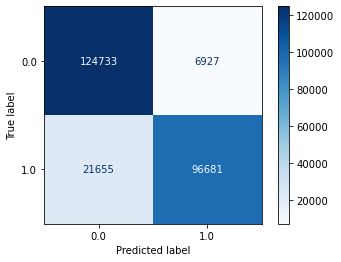

In [94]:
# plotting confusion matrix
plot_confusion_matrix(final_model, X_test_feats, y_test, cmap=plt.cm.Blues)

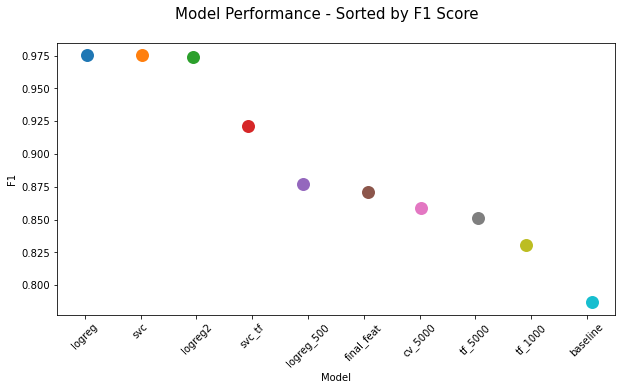

In [95]:
## Model Comparison - Sorted by F1 score
scores_viz_f1 = scores.sort_values(by=['f1_test'], ascending=False)[1:].reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
sns.stripplot(x="index", y="f1_test", data=scores_viz_f1, size=13)
plt.xticks(rotation = 45)
ax.set_xlabel("Model", fontsize=10)
ax.set_ylabel("F1", fontsize=10)
fig.suptitle("Model Performance - Sorted by F1 Score", fontsize=15)
plt.savefig('images/model_f1_comp.png')

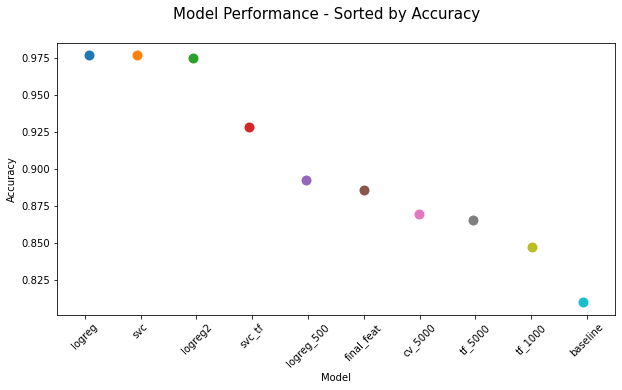

In [96]:
## Model Comparison - Sorted by Accuracy
scores_viz_ac = scores.sort_values(by=['accuracy_test'], ascending=False)[1:].reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
sns.stripplot(x="index", y="accuracy_test", data=scores_viz_ac, size=10)
plt.xticks(rotation = 45)
ax.set_xlabel("Model", fontsize=10)
ax.set_ylabel("Accuracy", fontsize=10)
fig.suptitle("Model Performance - Sorted by Accuracy", fontsize=15)
plt.savefig('images/model_ac_comp.png')

#### Final Model

The best-peforming model was a logistic regression classifier, with stopwords removed and max features capped at 5000. None of the engineered parameters improved performance significantly enough to include them in the classifier.

In [13]:
# storing the final X_train and X_test
final_X_train, final_X_test, y_hat_train, y_hat_test, col_names, score_table  = \
model_eval_store(LogisticRegression(), 'final', 
                 CountVectorizer(stop_words = stopwords_list, max_features=5000))

display(score_table)

/Users/natalyadoris/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,model,vectorizer
final,0.975459,0.975219,0.976928,0.97666,0.976336,0.965158,LogisticRegression(),"CountVectorizer(max_features=5000,\n ..."


Let's look at some visualizations of the final model performance.

In [14]:
final_model = LogisticRegression()
final_model.fit(final_X_train, y_train)

/Users/natalyadoris/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

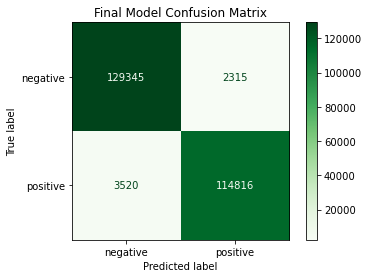

In [100]:
# Confusion matrix
g = plot_confusion_matrix(final_model, final_X_test, y_test, cmap=plt.cm.Greens)
g.ax_.set_title('Final Model Confusion Matrix')
g.ax_.xaxis.set_ticklabels(['negative', 'positive'])
g.ax_.yaxis.set_ticklabels(['negative', 'positive'])

plt.savefig('images/final_confusion_matrix.png')

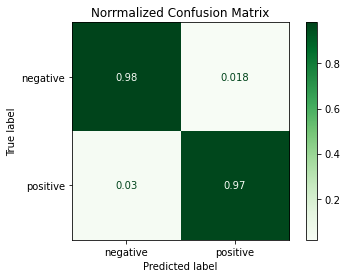

In [101]:
# Normalized Confusion Matrix
g = plot_confusion_matrix(final_model, final_X_test, y_test, cmap=plt.cm.Greens, 
                      normalize='true')
g.ax_.set_title('Norrmalized Confusion Matrix')
g.ax_.xaxis.set_ticklabels(['negative', 'positive'])
g.ax_.yaxis.set_ticklabels(['negative', 'positive'])

plt.savefig('images/final_confusion_matrix_normalized.png')

Plotting feature importance for the final model.

In [102]:
# Dataframe of regression coefficients for each feature (word)
coef_df = pd.DataFrame(final_model.coef_, columns=col_names).transpose()
coef_df.columns=['coef']
coef_df['coef_abs'] = abs(coef_df['coef'])

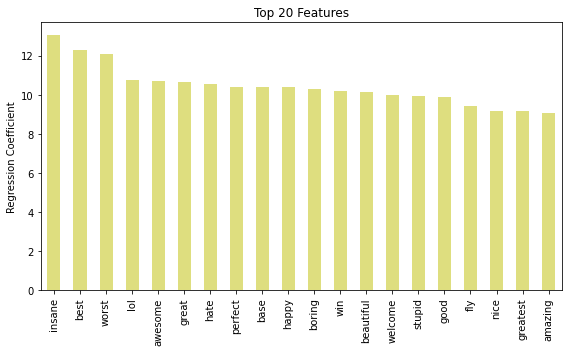

In [103]:
# Plotting the top 20 features (pos or neg)
top_20 = coef_df.sort_values(by='coef_abs', ascending=False)[:20]
fig, ax = plt.subplots(figsize = (8,5))
top_20['coef_abs'].plot.bar(ax=ax, color='y', alpha=0.5)  
ax.set_title("Top 20 Features")
ax.set_ylabel("Regression Coefficient")
fig.tight_layout()
plt.savefig('images/feat_importance_top20.png')

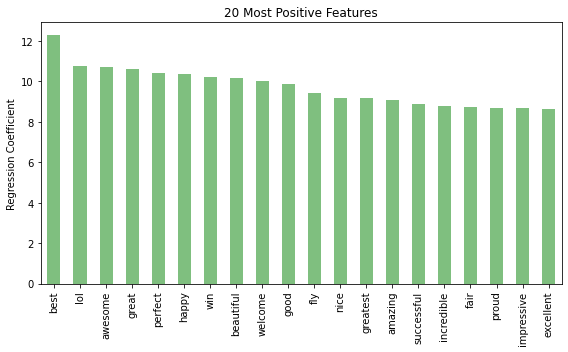

In [104]:
# Plotting the 20 most positive features
bottom_20 = coef_df.sort_values(by='coef', ascending=False)[:20]
fig, ax = plt.subplots(figsize = (8,5))
bottom_20['coef'].plot.bar(ax=ax, color='g', alpha=0.5)  
ax.set_title("20 Most Positive Features")
ax.set_ylabel("Regression Coefficient")
fig.tight_layout()
plt.savefig('images/feat_importance_pos20.png')

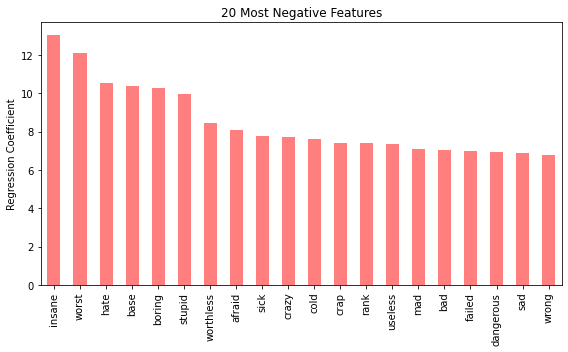

In [105]:
# Plotting the 20 most negative features
bottom_20 = coef_df.sort_values(by='coef', ascending=True)[:20]
fig, ax = plt.subplots(figsize = (8,5))
bottom_20['coef_abs'].plot.bar(ax=ax, color='r', alpha=0.5)  
ax.set_title("20 Most Negative Features")
ax.set_ylabel("Regression Coefficient")
fig.tight_layout()
plt.savefig('images/feat_importance_neg20.png')

#### Eval Final Model on New Data

In [19]:
new_data = pd.read_csv('data/crypto_10k_tweets_(2021_2022Nov).csv', lineterminator='\n')
new_data.head()

,Unnamed: 0,Date,Username,Content,URL,Hashtags
0,0,2022-11-30 11:53:21+00:00,0xEthereumYoda,#Ethereum price update: \n\n#ETH $1269.23 USD\...,https://twitter.com/0xEthereumYoda/status/1597...,"['Ethereum', 'ETH', 'Bitcoin', 'BTC', 'altcoin..."
1,1,2022-11-30 11:53:21+00:00,Lawrenc32984128,@mtmalinen @ecb Do well to understand that eve...,https://twitter.com/Lawrenc32984128/status/159...,['BTC']
2,2,2022-11-30 11:53:21+00:00,NITESHP55784410,Kayla #Ethereum Harold #世界杯 Egbert #百家乐 Lavern...,https://twitter.com/NITESHP55784410/status/159...,"['Ethereum', '世界杯', '百家乐', '世界杯买球']"
3,3,2022-11-30 11:53:20+00:00,817coin,#Bitcoin https://t.co/2koLlCvCri https://t.co/...,https://twitter.com/817coin/status/15979217174...,['Bitcoin']
4,4,2022-11-30 11:53:18+00:00,slamtoken,"Yesterday we made a 3,000 SLAM buyback and loc...",https://twitter.com/slamtoken/status/159792171...,"['slamtoken', 'bnb', 'bsc']"


In [23]:
new_data['date'] = [datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S%z') for date in new_data['Date']]
new_data['date'] = pd.to_datetime(new_data['Date']).dt.date

In [24]:
text_data_new = new_data[['Content', 'Hashtags', 'date']]
text_data_new.head()

,Content,Hashtags,date
0,#Ethereum price update: \n\n#ETH $1269.23 USD\...,"['Ethereum', 'ETH', 'Bitcoin', 'BTC', 'altcoin...",2022-11-30
1,@mtmalinen @ecb Do well to understand that eve...,['BTC'],2022-11-30
2,Kayla #Ethereum Harold #世界杯 Egbert #百家乐 Lavern...,"['Ethereum', '世界杯', '百家乐', '世界杯买球']",2022-11-30
3,#Bitcoin https://t.co/2koLlCvCri https://t.co/...,['Bitcoin'],2022-11-30
4,"Yesterday we made a 3,000 SLAM buyback and loc...","['slamtoken', 'bnb', 'bsc']",2022-11-30


In [25]:
text_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Content   10000 non-null  object
 1   Hashtags  10000 non-null  object
 2   date      10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


In [30]:
pattern_https = "https:\/\/t.co\/[a-zA-Z0-9\-\.]{8}"
pattern_www = "www\.[a-z]?\.?(com)+|[a-z]+\.(com)"
repl = ''


text_data_new['text'] = [re.sub(pattern_https, repl, string, count=0, flags=0)\
                         for string in text_data_new['Content']]
text_data_new['text'] = [re.sub(pattern_www, repl, string, count=0, flags=0)\
                         for string in text_data_new['Content']]

<ipython-input-30-3fa3e5981d3a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data_new['text'] = [re.sub(pattern_https, repl, string, count=0, flags=0)\
<ipython-input-30-3fa3e5981d3a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data_new['text'] = [re.sub(pattern_www, repl, string, count=0, flags=0)\


In [42]:
pattern_handle = "@[A-Za-z0-9]+"
repl = ''

text_data_new['text'] = [re.sub(pattern_handle, repl, string, count=0, flags=0)\
                         for string in text_data_new['text']]

<ipython-input-42-1d1a7099d2f9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data_new['text'] = [re.sub(pattern_handle, repl, string, count=0, flags=0)\


In [46]:
# remove numbers

pattern_num = r"\b\d+\b" #"\b(\d+)\b"
repl = ''

text_data_new['text'] = [re.sub(pattern_num, repl, string, count=0, flags=0)\
                         for string in text_data_new['text']]

text_data_new['text'].head()

<ipython-input-46-836f8cee6ca0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data_new['text'] = [re.sub(pattern_num, repl, string, count=0, flags=0)\


0    #ethereum price update:   #eth $. usd #bitcoin...
1    do well to understand that every dip in the pr...
2    kayla #ethereum harold #世界杯 egbert #百家乐 lavern...
3                                             #bitcoin
4    yesterday we made a , slam buyback and locked ...
Name: text, dtype: object

In [37]:
pattern_tco = "https:\/\/t.co\/([a-zA-Z0-9_]+)"

text_data_new['text'] = [re.sub(pattern_tco, repl, string, count=0, flags=0)\
                         for string in text_data_new['Content']]

text_data_new['text'][3]

<ipython-input-37-64c07dbedd42>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data_new['text'] = [re.sub(pattern_tco, repl, string, count=0, flags=0)\


'#Bitcoin  '

In [38]:
text_data_new['text'] = text_data_new["text"].str.lower()

<ipython-input-38-da259f939598>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data_new['text'] = text_data_new["text"].str.lower()


In [40]:
text_data_new['text'] = [tweet.replace("\n", " ") for tweet in text_data_new['text']]

<ipython-input-40-aeb736b72a8a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data_new['text'] = [tweet.replace("\n", " ") for tweet in text_data_new['text']]


In [44]:
text_data_new['text'] = [tweet.strip() for tweet in text_data_new['text']]

<ipython-input-44-d027619a5642>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data_new['text'] = [tweet.strip() for tweet in text_data_new['text']]


In [45]:
text_data_new['text'].head()

0    #ethereum price update:   #eth $1269.23 usd #b...
1    do well to understand that every dip in the pr...
2    kayla #ethereum harold #世界杯 egbert #百家乐 lavern...
3                                             #bitcoin
4    yesterday we made a 3,000 slam buyback and loc...
Name: text, dtype: object

In [51]:
final_model = LogisticRegression()
vectorizer = CountVectorizer(stop_words = stopwords_list, max_features=5000)

X_train_vectorized = vectorizer.fit_transform(X_train['text'])
new_data_vec = vectorizer.transform(text_data_new['text'])

final_model.fit(X_train_vectorized, y_train)

new_preds = final_model.predict(new_data_vec)
new_preds

#col_names = vectorizer.get_feature_names()

/Users/natalyadoris/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0., 1., 0., ..., 1., 0., 0.])

In [55]:
a = pd.Series(new_preds)
    
    
results_df = pd.concat([text_data_new['text'], a], axis=1)
results_df.columns = ['tweet', 'sentiment_prediction']

In [56]:
results_df

,tweet,sentiment_prediction
0,#ethereum price update: #eth $. usd #bitcoin...,0.0
1,do well to understand that every dip in the pr...,1.0
2,kayla #ethereum harold #世界杯 egbert #百家乐 lavern...,0.0
3,#bitcoin,0.0
4,"yesterday we made a , slam buyback and locked ...",0.0
...,...,...
9995,digital rupee or e-rupee is a form of digital ...,1.0
9996,"in bear market, short every pump n dca every u...",0.0
9997,take that high and i’m max short #btc,1.0
9998,في خطة التوسع حول العالم، باينانس تستحوذ على م...,0.0


#### Sequence Model

In [71]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from nltk import word_tokenize
from gensim.models import word2vec
import tensorflow as tf

In [77]:
y_s = pd.get_dummies(y)
y_s

,0.0,1.0
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
999976,1,0
999977,0,1
999978,1,0
999979,0,1


In [62]:
X['text3'] = X['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','', x)))

tokenizer = text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(list(X['text3']))
list_tokenized_headlines = tokenizer.texts_to_sequences(X['text3'])
X_t = sequence.pad_sequences(list_tokenized_headlines, maxlen=100)

In [78]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_t, y_s, random_state = 42)
print(X_train_s.shape, y_train_s.shape)
print(X_test_s.shape, y_test_s.shape)

(749985, 100) (749985, 2)
(249996, 100) (249996, 2)


In [79]:
tf.keras.backend.clear_session()

In [50]:
# take 1
embedding_size = 128

model = Sequential()
model.add(Embedding(1000, embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(41, activation='softmax'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         128000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 25)          15400     
_________________________________________________________________
global_max_pooling1d (Global (None, 25)                0         
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                1300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 41)                2

In [53]:
# 1hr runtime, super low accuracy
model.fit(X_t, y, epochs=3, batch_size=32, validation_split=0.2)

Epoch 1/3
25000/25000 [==============================] - 1103s 44ms/step - loss: 1.7533 - accuracy: 0.0304 - val_loss: 1.8332 - val_accuracy: 0.0000e+00
Epoch 2/3
25000/25000 [==============================] - 1091s 44ms/step - loss: 1.7533 - accuracy: 0.0227 - val_loss: 1.8332 - val_accuracy: 0.0000e+00
Epoch 3/3
25000/25000 [==============================] - 1103s 44ms/step - loss: 1.7533 - accuracy: 0.0218 - val_loss: 1.8332 - val_accuracy: 0.0000e+00


In [80]:
# take 2
tf.keras.backend.clear_session()

embed_dim = 128
lstm_out = 196
max_features=1000

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X_t.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(25, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          128000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 25)                15400     
_________________________________________________________________
dense (Dense)                (None, 2)                 52        
Total params: 143,452
Trainable params: 143,452
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#max_fatures = 2000
#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
#tokenizer.fit_on_texts(data['text'].values)
#X = tokenizer.texts_to_sequences(data['text'].values)
#X = pad_sequences(X)

In [82]:
batch_size = 32
model.fit(X_train_s, y_train_s, epochs=3, batch_size=batch_size)#, verbose=2)

Epoch 1/3
  230/23438 [..............................] - ETA: 47:06 - loss: 0.3295 - accuracy: 0.8734

KeyboardInterrupt: 

In [69]:
X_train_s.shape

(749985, 100)

## Conclusion, Recommendations and Next Steps

- A Logistic Regression model was the best-performing classifier, with Count Vectorization used to process the annotated tweets
- 97% accuracy, 97% F1 score indicates model captures positive cases (recall) without casting too wide a net, i.e. little misclassification in either direction (precision) 
- Words important to the model included ‘best’, ‘awesome’, ‘successful’, ‘insane’, ‘worst’, ‘worthless’
- Positive tweets had more hashtags on average, negative tweets more frequently contained a price
- Next steps include running the model on real-time Tweets about Bitcoin, pulled via Twitter API, and conducting Time Series Analysis to undestand the predictive power of Tweet sentiment on the price of BTC



## Appendix

In [ ]:
#X_train_vec_df = pd.DataFrame(X_train_vec.toarray())
#X_train_vec_df.columns = col_names

encoder = LabelEncoder()
contains_price_train = pd.Series(encoder.fit_transform(X_train['contains_price']))

final_X_train = pd.concat([X_train_vec_df, 
                           contains_price_train, 
                           X_train[['hashtag_count']], 
                           X_train[['tweet_length']]
                          ], axis=1)

#final_X_train.head()

# I've had performance issues concatenating a large number of DataFrames to a 'growing' DataFrame. My workaround was appending all sub DataFrames to a list, and then concatenating the list of DataFrames once processing of the sub DataFrames has been completed.

In [ ]:
final_model = LinearSVC()

cv = CountVectorizer(stop_words = stopwords_list)

#final_X_train = cv.fit_transform(X_train['text'])

#####
X_train_vec = cv.fit_transform(X_train['text'])
X_train_vec_df = pd.DataFrame(X_train_vec.toarray(), 
                              columns=cv.get_feature_names())

# label encoding boolean column
encoder = LabelEncoder()
contains_price_train = pd.Series(encoder.fit_transform(X_train['contains_price']))

final_X_train = pd.concat([X_train_vec_df, 
                           contains_price_train, 
                           X_train[['hashtag_count']], 
                           X_train[['tweet_length']]
                          ], axis=1)

####
                                  
final_model.fit(final_X_train, y_train)
print(final_model.score(final_X_train, y_train))

# X test                           
#final_X_test = cv.transform(X_test["text"])
                           
####
X_test_vec = cv.transform(X_test["text"])
X_test_vec_df = pd.DataFrame(X_test_vec.toarray(), 
                              columns=cv.get_feature_names())

contains_price_test = pd.Series(encoder.transform(X_test['contains_price']))

final_X_test = pd.concat([X_test_vec, 
                          contains_price_test, 
                          X_test[['hashtag_count']], 
                          X_test[['tweet_length']]
                         ], axis=1)
                           

print(final_model.score(final_X_test, y_test))

plot_confusion_matrix(final_model, final_X_test, y_test)


In [ ]:
display(scores)

# plotting confusion matrix
plot_confusion_matrix(final_model, final_X_test, y_test, cmap=plt.cm.Blues)
#ax.title('Final Model Confusion Matrix')
#plt.show()
plt.savefig('images/final_confusion_matrix.png')

In [ ]:
# Precision Recall Curve

#fit logistic regression model to dataset
classifier = LogisticRegression()
classifier.fit(final_X_train, y_train)

#use logistic regression model to make predictions
y_score = classifier.predict_proba(final_X_test)[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()
plt.savefig('images/precision_recall_curve.png')

In [ ]:
y_hat_train_final = final_model.predict(final_X_train)
y_hat_test_final = final_model.predict(final_X_test)
display(scoreTable(final_model, 'final_model', y_train, y_hat_train_final, y_test, y_hat_test_final))

In [ ]:
#pd.DataFrame.sparse.from_spmatrix(final_X_train, columns=col_names)

In [ ]:
# Confusion Matrix - with seaborn
fig, ax = plt.subplots(figsize = (5,5))
cm = confusion_matrix(y_test, y_hat_test)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_title('Final Model Confusion Matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['negative', 'positive'])
ax.yaxis.set_ticklabels(['negative', 'positive'])

Let's see if we get better insights from looking at pairs of words. We will only focus on the top 450 most frequent words due to long runtimes.

In [ ]:
# top 450 words

# explode
#text_data["hashtag"][text_data['sentiment']==1].explode()

# subset for only top 450 words
# value count bigrams, trigrams, 4-grams

#nltk.bigrams()

#n_gram_pos = (pd.Series(nltk.ngrams(text_data['text_without_stopwords'][text_data['sentiment']==1], 2)).value_counts())[:10] #Setting up positive ngram
#n_gram_neg = (pd.Series(nltk.ngrams(tokens_neg, 2)).value_counts())[:10] #Setting up negative ngram
#n_gram_pos

In [ ]:
# long runtime
model_eval(LogisticRegression(solver='saga', penalty='l1', max_iter=5000), 'logreg3', 
           CountVectorizer(stop_words = stopwords_list, max_features=5000))